In [1]:
import os
import gc
import random

import numpy as np

import rasterio

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Callable, Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor

from torchvision.utils import make_grid

from torchgeo.datasets import (RasterDataset, 
                               stack_samples, 
                               splits, 
                               random_bbox_splitting)

from skimage.util import img_as_ubyte, img_as_float32, img_as_float, img_as_float64
from skimage import io

from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

from torchinfo import summary
from torchmetrics.classification import (MulticlassF1Score, 
                                         MulticlassConfusionMatrix, 
                                         MulticlassJaccardIndex)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, jaccard_score, f1_score

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import SoftCrossEntropyLoss, FocalLoss

from einops import rearrange

from pprint import pprint

from tqdm.auto import tqdm, trange

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = 'retina'

In [2]:
config = {
    'seed': 2024,
    'batch_size': 128,
    'num_classes': 3,    
    'ignore_index': 2,
    'in_channels': 4, 
    'model': 'DeepLabV3Plus',
    'encoder_name': 'efficientnet-b0',
    'trial': 1,
    'size': (224, 224),
}

In [3]:
# https://pytorch.org/docs/stable/notes/randomness.html
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(mode=True)
    torch.backends.cudnn.benchmark = True

seed_everything(config['seed'])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading data

In [5]:
def load_tif_image(patch: str) -> Tuple[np.array, list]:
    with rasterio.open(patch, mode='r') as src:
        arr = src.read()
        img = np.moveaxis(arr, 0, -1)
        profile = src.profile

    return img, profile

In [7]:
class SARImages(RasterDataset):

    filename_glob = '*.tif'
    is_image = True
    separate_files = False
    all_bands = ['VV', 'VH']

In [8]:
class SARLabels(RasterDataset):

    filename_glob = '*.tif'
    is_image = False
    all_bands = [0]

In [9]:
# Load SAR images
img_2019 = SARImages('./data/19229.tif')
img_2020 = SARImages('./data/20218.tif')

# Load labels
test_label  = SARLabels('./data/label_2020.tif')

In [10]:
test_data = img_2019 & img_2020 & test_label  # dimensions: [H, H, 5]

### Preparing data to feed the model

In [11]:
test_sampler = GridGeoSampler(test_data, size=config['size'], stride=config['size'])
testloader = DataLoader(test_data, batch_size=config['batch_size'], sampler=test_sampler, collate_fn=stack_samples)

### Model architecture

In [12]:
model = getattr(smp, config['model'])(
    encoder_name=config['encoder_name'],    
    encoder_weights='imagenet',             
    in_channels=config['in_channels'],
    classes=config['num_classes'],
)

In [13]:
model.to(device)

# load the last checkpoint with the best model
checkpoint = f"./models/{config['encoder_name']}_{config['trial']}.pt"
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

### Predictions

In [14]:
@torch.no_grad()
def get_predictions(model, dataloader):
    
    model.eval() 
    
    metric = MulticlassF1Score(num_classes=config['num_classes'], 
                               average='macro',
                               ignore_index=config['ignore_index']).to(device=device)
    
    cm_metric = MulticlassConfusionMatrix(num_classes=config['num_classes'],  
                                          ignore_index=config['ignore_index'], 
                                          normalize='true').to(device=device)

    jaccard_metric = MulticlassJaccardIndex(num_classes=config['num_classes'],
                                            average='macro',
                                            ignore_index=config['ignore_index']).to(device=device)

    test_imgs, y_true, y_pred = (torch.tensor([], device=device), 
                                 torch.tensor([], device=device), 
                                 torch.tensor([], device=device))
    
    running_loss = 0.0

    for sample in tqdm(dataloader):
        images = sample['image'].to(device)
        labels = sample['mask'].squeeze().to(device)
        
        with torch.cuda.amp.autocast():  # autocasting
            outputs = model(images)

        # Compute metrics
        metric.update(outputs, labels)
        cm_metric.update(outputs, labels)
        jaccard_metric.update(outputs, labels)
       
        # Predict labels
        _, preds = torch.max(outputs, dim=1)
        
        y_true = torch.cat([y_true, labels], dim=0)
        y_pred = torch.cat([y_pred, preds], dim=0)
        
        # Garbage collection
        torch.cuda.empty_cache()
        _ = gc.collect()
        
    f1_macro = metric.compute()
    metric.reset()

    IoU = jaccard_metric.compute()
    jaccard_metric.reset()

    confusion_matrix = cm_metric.compute()
    cm_metric.reset()

    print(f'Test f1-score macro: {f1_macro:.5f}')
    print(f'Test IoU macro: {IoU:.5f}')
    
    return (y_true.detach().cpu().numpy(), 
            y_pred.detach().cpu().numpy(), 
            confusion_matrix.detach().cpu().numpy())

In [15]:
y_true, y_pred, confusion_matrix = get_predictions(model, testloader)

  0%|          | 0/20 [00:00<?, ?it/s]

Test f1-score macro: 0.89237
Test IoU macro: 0.82217


In [16]:
y_pred.shape

(2548, 224, 224)

    ResNet Cross-Entropy
        Test f1-score macro: 0.87356
        Test IoU macro: 0.79708
    
    ResNet Focal Loss 
        Test f1-score macro: 0.88070
        Test IoU macro: 0.80642

    Efficient net CrossEntropy
        Test f1-score macro: 0.89209
        Test IoU macro: 0.82178
    
    Efficient net Focal Loss    
        Test f1-score macro: 0.55264
        Test IoU macro: 0.74329
    

### Plotting predictions

In [18]:
sar_img_labels = io.imread('./data/label_2020.tif')

In [19]:
original_shape = (10970, 11567)

h = (original_shape[0] // config['size'][0]) + 1
w = (original_shape[1] // config['size'][0]) + 1

# Sanity check
print(h, w)

49 52


In [20]:
y_true_reconstructed = rearrange(y_true, '(h w) c1 c2 -> (h c1) (w c2)', h=h, w=w)
y_pred_reconstructed = rearrange(y_pred, '(h w) c1 c2 -> (h c1) (w c2)', h=h, w=w)

y_true_reconstructed.shape, y_pred_reconstructed.shape

((10976, 11648), (10976, 11648))

In [21]:
def create_color_map():
    colormap = np.zeros((3, 3), dtype=int)
    colormap[0] = [0, 128, 0]        # deep green for no deforestation (vegetation/forest)
    colormap[1] = [255, 0, 0]        # red for deforestation
    colormap[2] = [192, 192, 192]    # Light grey for background
    return colormap

def apply_color_map(labeled_image, colormap):
    height, width = labeled_image.shape
    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    for label in range(config['num_classes']):
        mask = labeled_image == label
        color_image[mask] = colormap[label]
    
    return color_image

colormap = create_color_map()

# Apply the color map to the labeled image
y_true_colored = apply_color_map(y_true_reconstructed, colormap)
y_pred_colored = apply_color_map(y_pred_reconstructed, colormap)

y_true_colored.shape, y_pred_colored.shape

((10976, 11648, 3), (10976, 11648, 3))

CPU times: user 34 s, sys: 3.4 s, total: 37.4 s
Wall time: 36.8 s


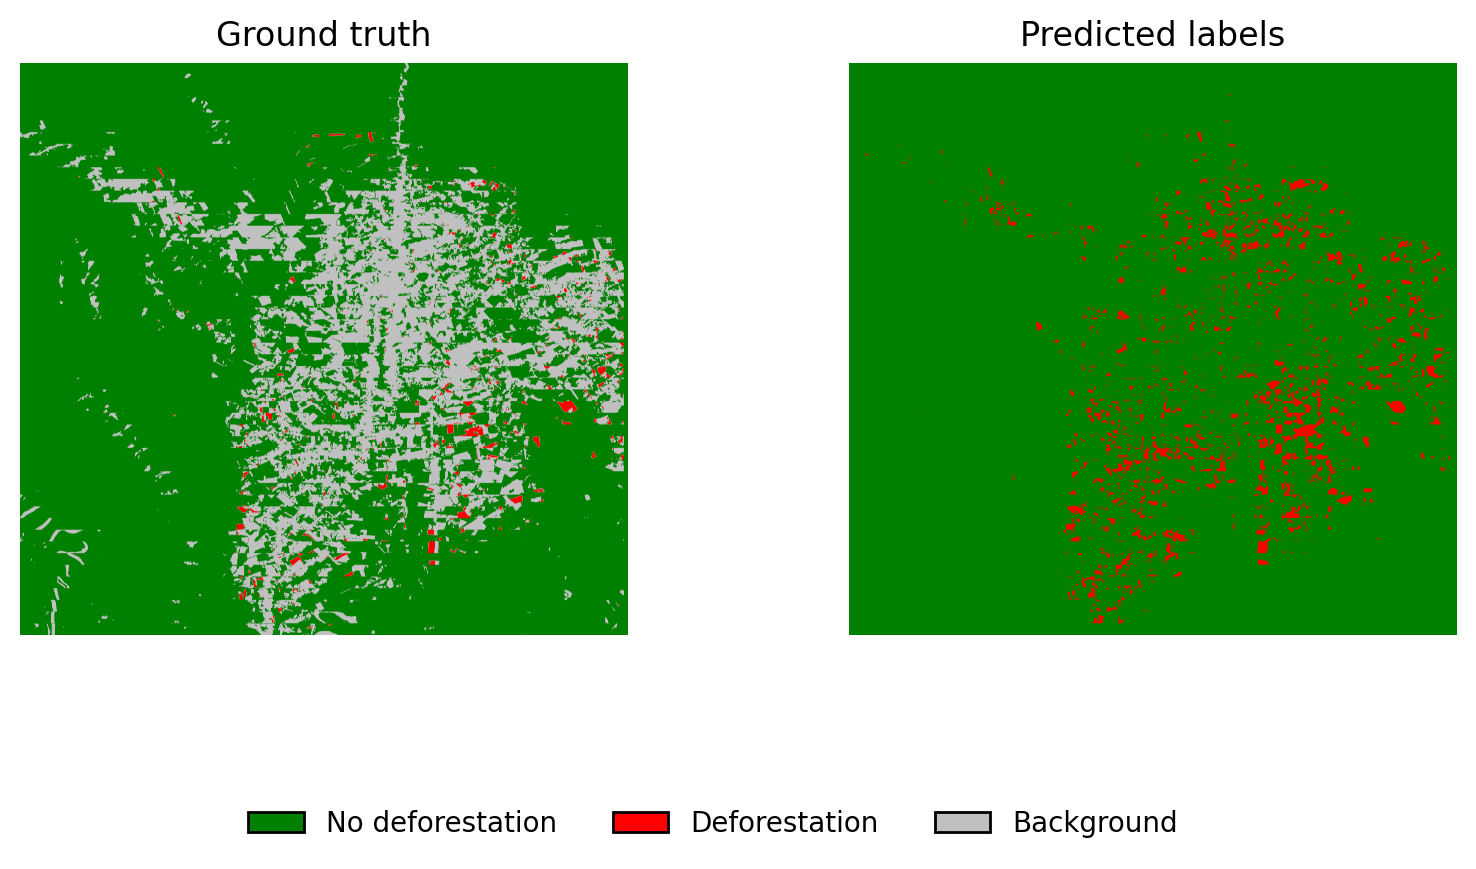

In [25]:
%%time

from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 2, figsize=[10, 4], layout='constrained')

ax[0].imshow(y_true_colored)
ax[0].set_title('Ground truth')
ax[0].axis('off')

ax[1].imshow(y_pred_colored)
ax[1].set_title('Predicted labels')
ax[1].axis('off')

# Create custom legend handles
legend_elements = [
    Patch(facecolor=np.array(colormap[0]) / 255, edgecolor='k', label='No deforestation'),
    Patch(facecolor=np.array(colormap[1]) / 255, edgecolor='k', label='Deforestation'),
    Patch(facecolor=np.array(colormap[2]) / 255, edgecolor='k', label='Background')
]

fig.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, -0.05), 
           ncol=3, 
           frameon=False)

plt.savefig(f"./assets/predictions_{config['encoder_name']}_{config['trial']}.png", bbox_inches='tight', dpi=300)

plt.tight_layout();

In [26]:
confusion_matrix

array([[0.99764526, 0.00235474, 0.        ],
       [0.19970736, 0.8002926 , 0.        ],
       [0.        , 0.        , 0.        ]], dtype=float32)

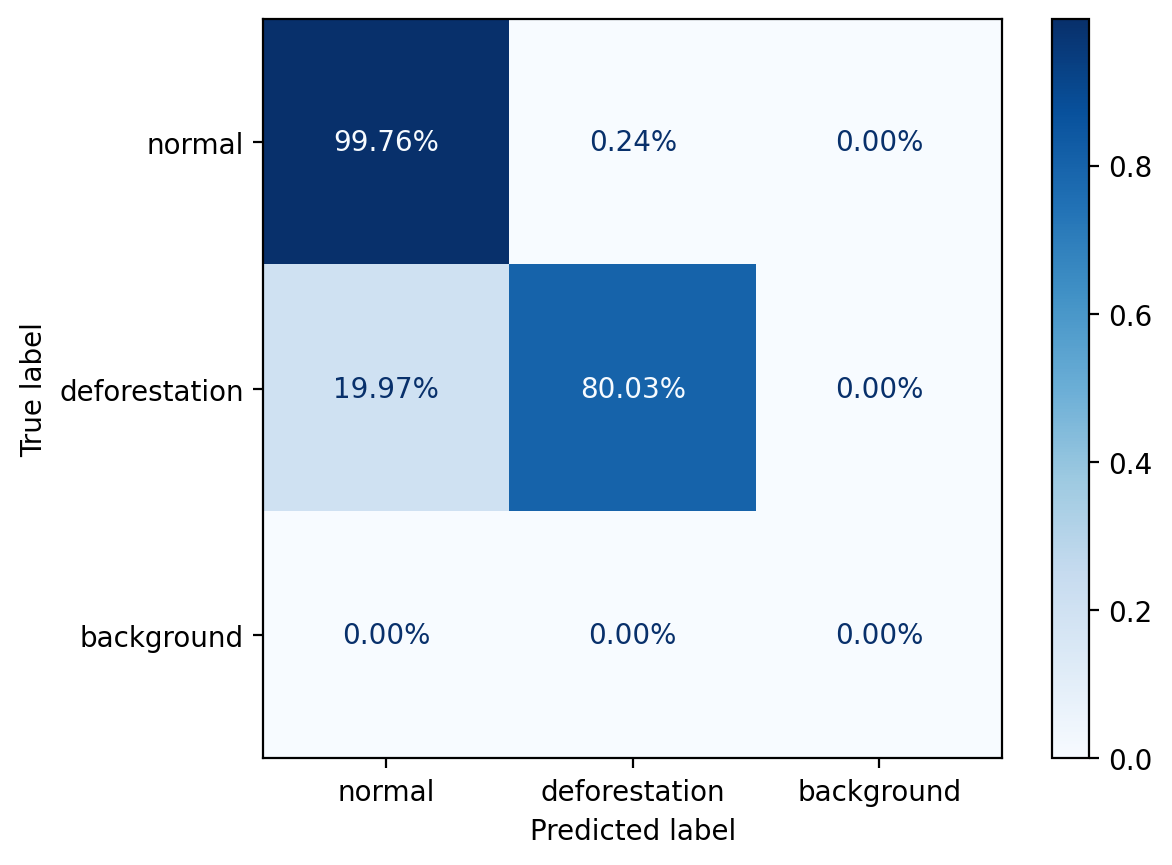

In [27]:
# 0-Não desmatamento
# 1-Desmatamento dentro do periodo
# 2-Desmatamento anterior ao periodo e background (desconsiderar essa classe)

cm = ConfusionMatrixDisplay(confusion_matrix, display_labels=['normal', 'deforestation', 'background'])
cm.plot(cmap='Blues', values_format='.2%');